# Tutorial 5 - Introduction to Lag Regression

This notebook will cover a implementation of Lag Regression according to all aspects of the data engineering process from data retrival all the way to a final output.

## Packages
Here we have a list of packages that we use to help use transform, model, and visualize our data. Below are descriptions for these.

 - Pandas: Used to manage our data in a structured format (Usually using Dataframes, table like structures)
 - Numpy: Used to manage our data and gives us more operations to transform our data
 - Matplotlib: For visualizing our data and outcomes
 - Seaborn: Used for feature engineering and studying correlation metrics
 - Google Cloud: Used for data retrival from the Ironhacks BigQuery tables

In [ ]:
!pip install google-cloud-bigquery
!pip install google-cloud-bigquery[pandas]

In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

## Data Retrieval

This section will cover the code you need retrieve data from IronHacks. You'll need to make sure that you have your JSON key to be able to access the data. This data retrieval will general be same unless you change the query you would like. More on queries and SQL in Tutorial #3!

In [10]:
# CONFIGURE THE BIGQUERY SETTINGS

BIGQUERY_PROJECT = 'ironhacks-covid19-data'
BIGQUERY_KEYPATH = 'service-account.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = BIGQUERY_KEYPATH
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [11]:
query = """
SELECT *
FROM `ironhacks-covid19-data.ironhacks_covid19_training.weather_data`
"""

# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
data = query_job.to_dataframe()
data['date']= pd.to_datetime(data['date'])
data.head()

,date,max_rel_humidity,max_temperature,mean_temperature,min_rel_humidity,min_temperature,potential_water_deficit,precipitation_data,wind_speed
0,2019-10-12,69.2646,13.5804,7.6987,28.2524,1.8170,-3.0055,0.0,5.1240
1,2019-12-22,93.9565,11.8324,4.6358,34.5712,-2.5607,-1.2796,0.0,2.8557
2,2019-08-24,91.3571,24.6652,18.6607,44.4712,12.6562,-4.7381,0.0,4.4706
3,2020-07-14,90.5395,29.7732,23.1580,43.2159,16.5427,-5.8112,0.0,2.3504
4,2019-12-07,98.1103,6.4609,0.5011,42.7690,-5.4587,-0.9686,0.0,3.2087


## Data Cleaning

Lets start cleaning and understanding our data. Below is some functions to help split the data so you can work on them independently. This only shows a small portion of cleaning that you can do. If your data contains text strings and other variables types, you many need to figure out other methods to make that data usable. 

In [12]:
X = data.drop("wind_speed",1)   #Feature Matrix
X = data.drop("date",1)
y = data["wind_speed"]          #Target Variable

/tmp/ipykernel_49/3613689375.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = data.drop("wind_speed",1)   #Feature Matrix
/tmp/ipykernel_49/3613689375.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = data.drop("date",1)


## Feature Engineering

Now that we cleaned our data, we need to truly understand what is important to us when building the model. So we need understand the correlation between features and target variable. One way we can do this is by using a heatmap to understand the correlation between each variable. 

Below, we use the Filter method (Link here) to figure out which variables are the most important to use.

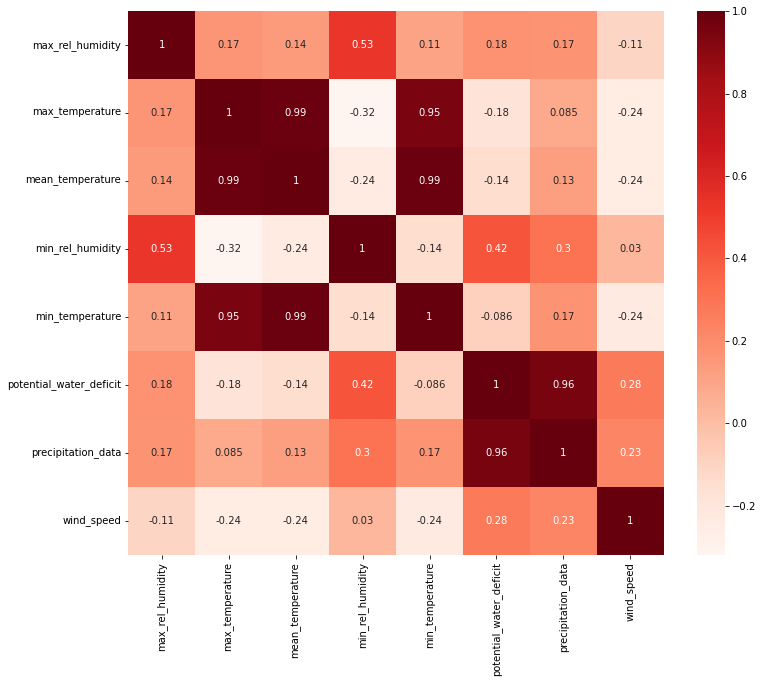

In [13]:
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Lots of great data here. But now lets narrow down what's important to us. Below, we can figure out which features are the more important to us. Lets say that ```potential_water_deficit``` was the target variable. Lets filter the variables that have a high correlation metric. We can than potentially use those to help us predict the outcome better instead of using every single feature. 

In [14]:
#Correlation with output variable
cor_target = abs(cor["potential_water_deficit"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

potential_water_deficit    1.000000
precipitation_data         0.956646
Name: potential_water_deficit, dtype: float64


## Visualizing the data

Here, we are going to do a few methods of visualizing the data and getting a better idea of what techniques we can do to get the best possible prediction for it.



array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

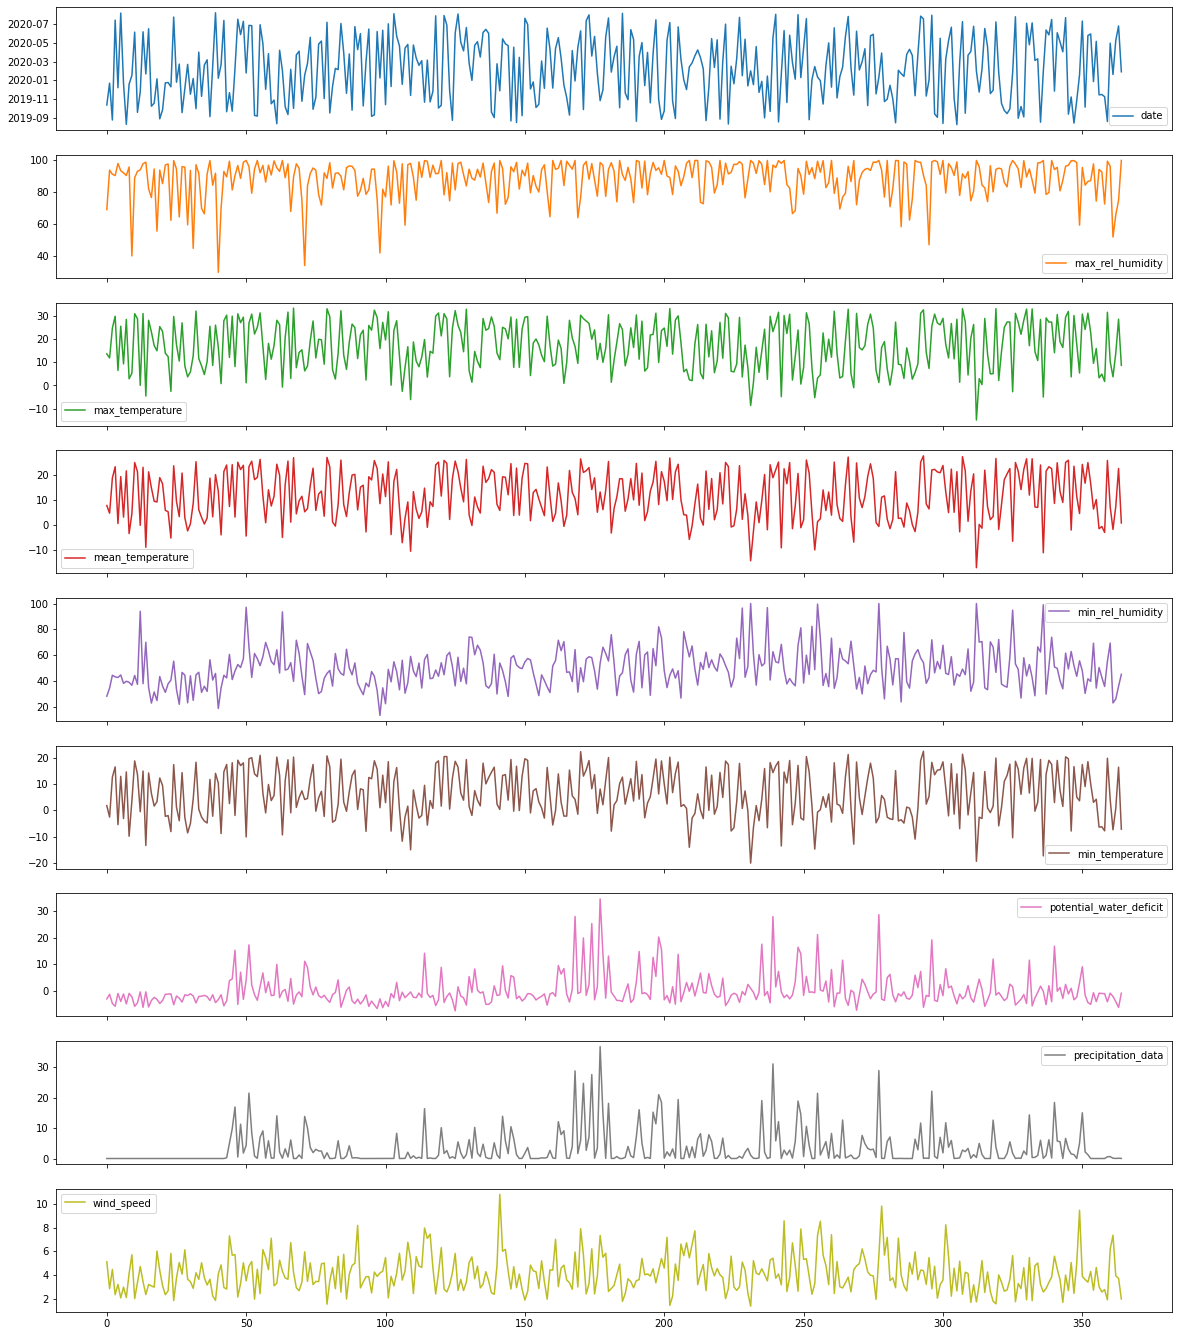

In [16]:
data.plot(subplots=True, figsize=(20,24))

In [17]:
min(data['date']),max(data['date'])

(Timestamp('2019-08-09 00:00:00'), Timestamp('2020-08-07 00:00:00'))

In [18]:
data.dtypes

date                       datetime64[ns]
max_rel_humidity                  float64
max_temperature                   float64
mean_temperature                  float64
min_rel_humidity                  float64
min_temperature                   float64
potential_water_deficit           float64
precipitation_data                float64
wind_speed                        float64
dtype: object

In [19]:
data = data.set_index('date')

In [20]:
data.index

DatetimeIndex(['2019-10-12', '2019-12-22', '2019-08-24', '2020-07-14',
               '2019-12-07', '2020-08-06', '2019-12-21', '2019-08-10',
               '2019-12-19', '2020-01-16',
               ...
               '2020-05-06', '2019-11-14', '2019-11-15', '2019-11-08',
               '2019-08-19', '2020-04-30', '2020-01-19', '2020-05-09',
               '2020-06-25', '2020-01-28'],
              dtype='datetime64[ns]', name='date', length=365, freq=None)

In [21]:
data['Year'] = data.index.year
data['Month'] = data.index.month
# Display a random sampling of 5 rows
data.sample(5, random_state=0)

,max_rel_humidity,max_temperature,mean_temperature,min_rel_humidity,min_temperature,potential_water_deficit,precipitation_data,wind_speed,Year,Month
date,,,,,,,,,,
2019-12-18,97.8910,-2.5306,-7.1461,56.1076,-11.7615,-0.4629,0.0022,3.5746,2019,12
2020-05-01,86.1188,19.9006,13.0803,35.6753,6.2600,-4.1807,0.0788,3.1970,2020,5
2019-09-22,81.5481,29.8013,23.9777,41.1183,18.1541,4.4834,9.7817,5.6722,2019,9
2020-02-22,64.6565,10.4822,3.2602,21.9975,-3.9619,-2.7102,0.0000,5.0548,2020,2
2019-11-02,92.2644,9.1528,3.4183,42.0694,-2.3161,-1.6305,0.0105,5.0141,2019,11


In [22]:
data.loc['2019-08']

,max_rel_humidity,max_temperature,mean_temperature,min_rel_humidity,min_temperature,potential_water_deficit,precipitation_data,wind_speed,Year,Month
date,,,,,,,,,,
2019-08-24,91.3571,24.6652,18.6607,44.4712,12.6562,-4.7381,0.0000,4.4706,2019,8
2019-08-10,90.5813,28.3985,21.5126,39.8397,14.6268,-4.8887,0.0000,2.1004,2019,8
2019-08-28,93.9562,25.3146,18.8246,43.4746,12.3346,-4.7147,0.0000,4.3852,2019,8
2019-08-12,95.4054,28.0463,24.1730,64.2389,20.2998,9.9964,14.0146,3.3058,2019,8
2019-08-23,98.3627,24.6563,18.4608,51.2616,12.2653,-3.4338,0.5794,4.1893,2019,8
2019-08-21,96.0526,29.4368,24.4074,57.8442,19.3779,5.7482,10.4608,2.8198,2019,8
2019-08-16,98.8423,28.4663,22.6356,52.5434,16.8048,-2.9397,1.2605,2.9367,2019,8
2019-08-20,99.9874,30.3163,24.4875,60.9037,18.6587,3.4321,7.2278,3.5280,2019,8
2019-08-26,91.3474,23.5543,21.1979,73.4626,18.8415,15.6467,18.4548,5.3918,2019,8


In [23]:
sns.set(rc={'figure.figsize':(11, 4)})

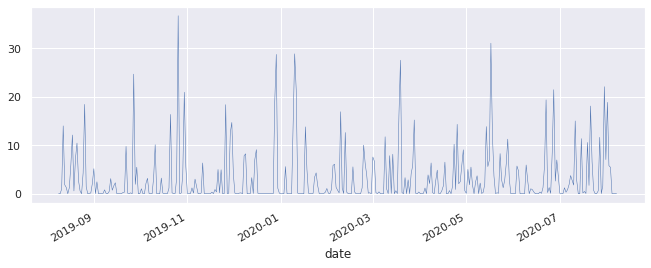

In [24]:
data['precipitation_data'].plot(linewidth=0.5);

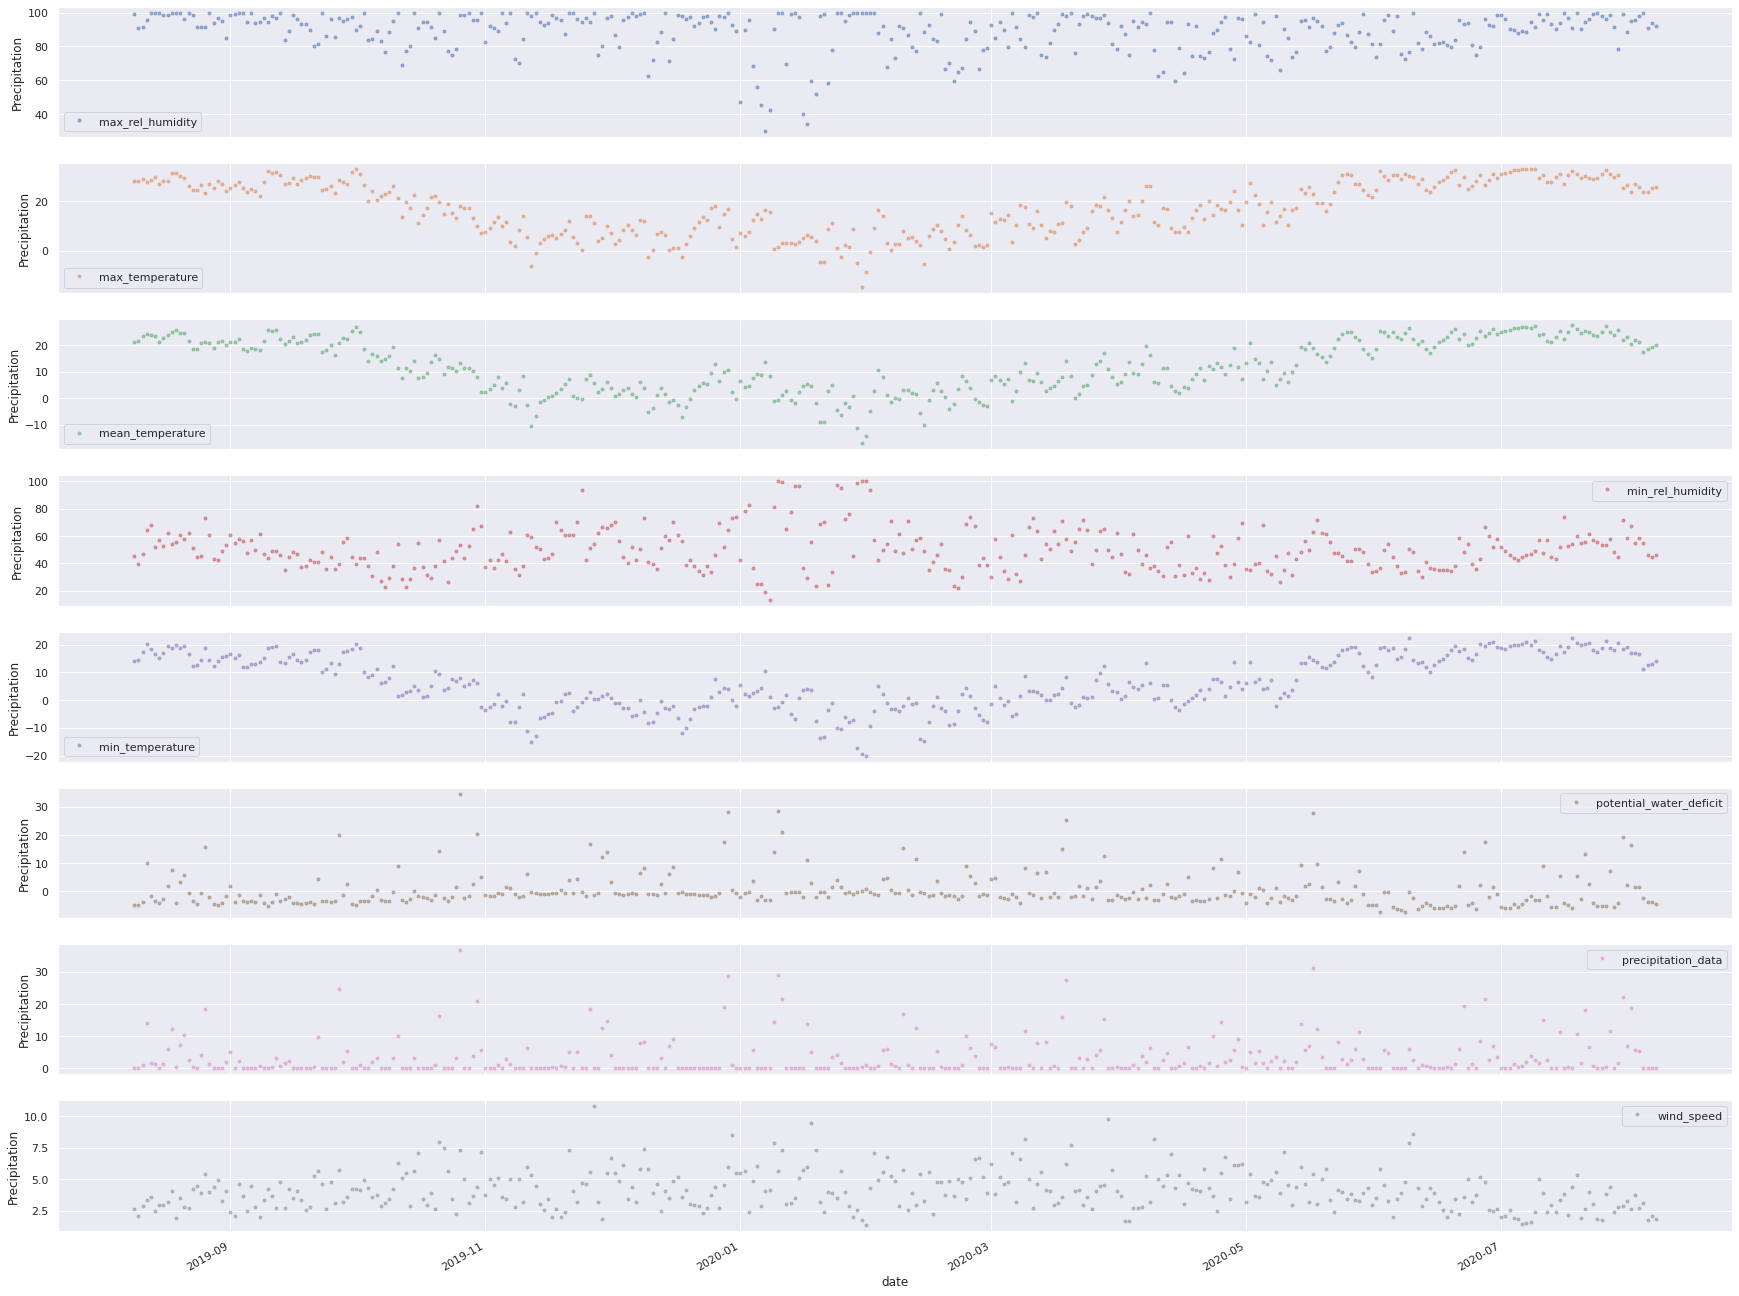

In [25]:
cols_plot = ['max_rel_humidity','max_temperature','mean_temperature','min_rel_humidity','min_temperature','potential_water_deficit','precipitation_data','wind_speed']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(30, 25), subplots=True)
for ax in axes:
    ax.set_ylabel('Precipitation')

/tmp/ipykernel_49/2539290912.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  ax.plot(data.loc['2019-08':'2019-12', 'precipitation_data'], marker='o', linestyle='-')


Text(0.5, 1.0, 'Aug 2019-2020 Precipiation Data')

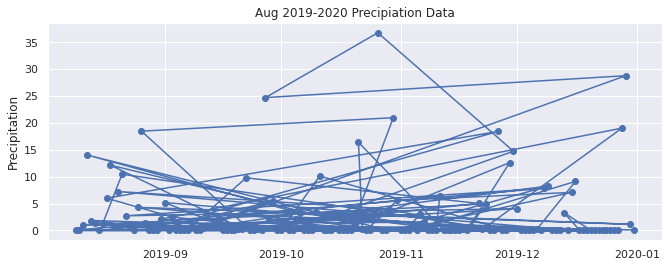

In [26]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.plot(data.loc['2019-08':'2019-12', 'precipitation_data'], marker='o', linestyle='-')
ax.set_ylabel('Precipitation')
ax.set_title('Aug 2019-2020 Precipiation Data')

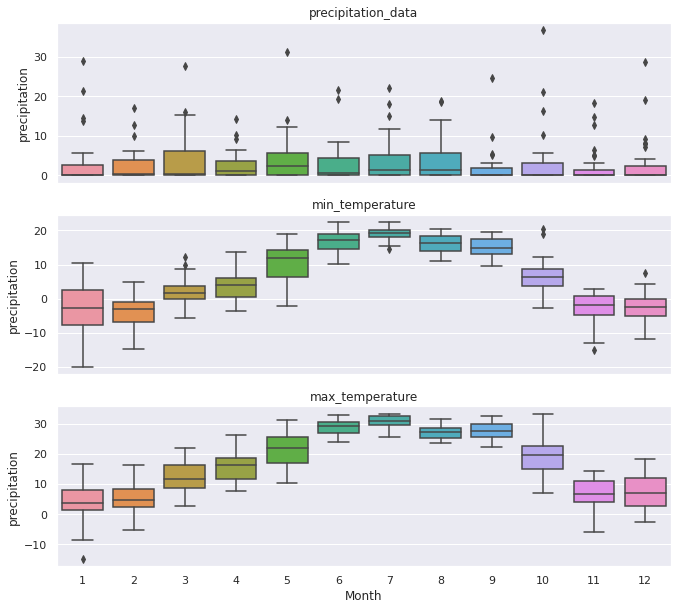

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['precipitation_data', 'min_temperature', 'max_temperature'], axes):
    sns.boxplot(data=data, x='Month', y=name, ax=ax)
    ax.set_ylabel('precipitation')
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

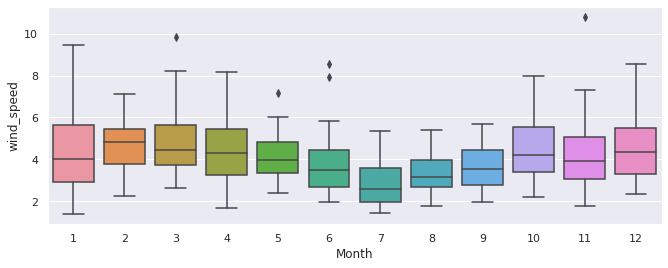

In [28]:
sns.boxplot(data=data, x='Month', y='wind_speed');

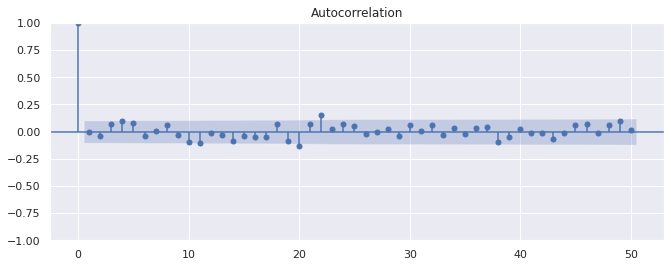

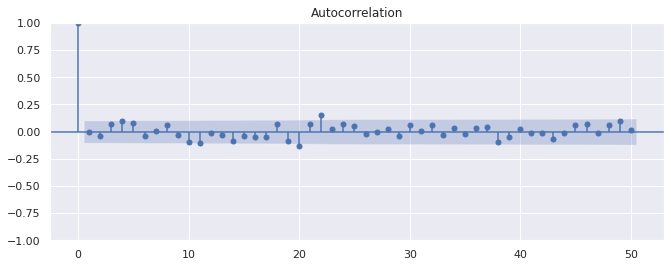

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(x=data['max_temperature'], lags=50)

## Modeling the Data

The tool we need to use to create predictions for us. Here we will show the steps needed to take your data and input it into a Lag Regression model. 

In [31]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [32]:
y_pred = pd.Series(model.predict(X), index=X.index)

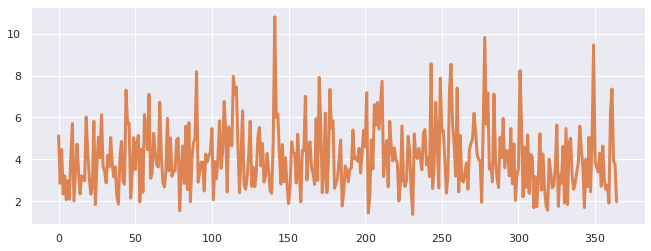

In [33]:
ax = y.plot(alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)

In [35]:
lag_1 = data['precipitation_data'].shift(1)

data['lag_1']=lag_1
